# Final Project 1: Assessing Population Dynamics in Pacific Small Island Developing States

### Adolphe Quetelet - Evan Anderson, Laure Ho, Jakob Mackanych, Noah Mujica, and Rania Nasser
#### EEP 153 - Population, Environment, and Development
#### February 11th 2025

Climate change will have far-reaching global consequences, however, in the near future, its impacts will perhaps be nowhere as pronounced and devastating as in the Pacific. 

According to a report by the World Meteorological Organization, "A triple whammy of accelerating sea level rise, ocean warming and acidification is imperilling Pacific Islands, which face growing threats to their socioeconomic viability and indeed their very existence because of climate change" (1). The IPCC identifies these nations as the most vulnerable places in the world to climate change (2).

Pacific Small Island Developing States (PSIDS) or Pacific Small States (PSS) are a group of 14 developing nations: Cook Islands, Federated State of Micronesia, Fiji, Kiribati, Nauru, Niue, Palau, Papua New Guinea, Marshall Islands, Samoa, Solomon Islands, Tonga, Tuvalu, and Vanuatu (3). 

Increased severity of natural disasters and floods will have far-reaching impacts: agriculture, freshwater, tourism, industry, and ecosystems are and will further experience damages. Climate risk therefore poses safety and security risks to the people of PSS states (2).

**How might population and development data illuminate the problems, risks, and patterns associated with climate impacts in the Pacific?**

Using development data from the World Bank, we will see how climate change will impact these states and their population dynamics. We will also compare those dynamics to a developed nation.

In [2]:
%pip install wbdata
%pip install iso3166
%pip install cufflinks
%pip install eep153_tools
%pip install plotly

import wbdata
import pandas as pd
import math
from datetime import datetime
import iso3166
import plotly.offline as py
from scipy.optimize import newton
import plotly.graph_objs as go
import numpy as np
import cufflinks as cf
from matplotlib import animation as ani
cf.go_offline()

  Using cached wbdata-1.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached backoff-2.2.1-py3-none-any.whl.metadata (14 kB)
  Using cached dateparser-1.2.1-py3-none-any.whl.metadata (29 kB)
  Using cached shelved_cache-0.3.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached tabulate-0.8.10-py3-none-any.whl.metadata (25 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzlocal-5.2-py3-none-any.whl.metadata (7.8 kB)
Using cached wbdata-1.0.0-py3-none-any.whl (18 kB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Using cached backoff-2.2.1-py3-none-any.whl (15 kB)
Using cached dateparser-1.2.1-py3-none-any.whl (295 kB)
Using cached shelved_cache-0.3.1-py3-none-any.whl (7.8 kB)
Using cached tabulate-0.8.10-py3-none-any.whl (29 kB)
Using cached pytz-2025.1-py2.py3-none-any.whl (507 kB)
Using cached tzlocal-5.2-py3-none-any.whl (17 kB)
  Attempting uninstall: pytz
    Found exist

Key '-2388156241167128203' not in persistent cache.
Key '3431757814371305464' not in persistent cache.
Key '6242761201888591431' not in persistent cache.
Key '2552469945934821605' not in persistent cache.
Key '-8684913357273075916' not in persistent cache.
Key '1600443539796580528' not in persistent cache.
Key '2217603736144650137' not in persistent cache.
Key '-1926516234290392028' not in persistent cache.
Key '752762074309721120' not in persistent cache.
Key '6704401208765327606' not in persistent cache.
Key '-424420421092801703' not in persistent cache.
Key '4144083553732215656' not in persistent cache.
Key '-9129151551415514881' not in persistent cache.
Key '617123779645243100' not in persistent cache.
Key '3881955881643801406' not in persistent cache.
Key '-334902626492997977' not in persistent cache.
Key '411931807918922550' not in persistent cache.
Key '3637995602536158631' not in persistent cache.
Key '3931001322466806819' not in persistent cache.
Key '5352557995020872358' not 

## Population Statistics Function

We begin by defining a function to easily access a population estimate given standard parameters.

In [6]:
#Match World Bank age ranges to a given sex
def get_matching_indicators(age_range, sex):
    age_ranges = [f"{i:02d}{i+4:02d}" for i in range(0, 80, 5)] + ["80UP"]
    male_variables = {f"SP.POP.{age}.MA": f"Males {age}" for age in age_ranges}
    female_variables = {f"SP.POP.{age}.FE": f"Females {age}" for age in age_ranges}

    #Creates dictionary for sex variables
    variables = male_variables.copy()
    variables.update(female_variables)

    #Matches age to given sex, and includes "People"
    indicators = []
    for age in age_helper(age_range):
        if sex == "People":
            indicators.append(f"SP.POP.{age}.MA")
            indicators.append(f"SP.POP.{age}.FE")
        elif sex == "Males":
            indicators.append(f"SP.POP.{age}.MA")
        elif sex == "Females":
            indicators.append(f"SP.POP.{age}.FE")
    return indicators

#Converting given age range into World Bank ranges
def age_helper(age_range):
    lower_bound = 5 * (min(age_range) // 5)
    upper_bound = 5 * round(max(age_range) // 5)
    age_groups = ["{:02}{:02}".format(i, i+4) for i in range(lower_bound, min(80, upper_bound+1), 5)]

    if upper_bound >= 80:
        age_groups.append("80UP")

    return age_groups

#Create population function
def population(year, sex, age_range, place):
    current_year = datetime.now().year
    if not (1960 <= year <= current_year):
        raise ValueError("Please choose another year that is between 1960 and this year.")
    if sex not in ["People", "Males", "Females"]:
        raise ValueError("Please choose from the following 3 options: 'People', 'Males', 'Females'")

    indicators = get_matching_indicators(age_range, sex)

    try:
        data = wbdata.get_dataframe({ind: ind for ind in indicators}, country = place, date = f"{year}-01-01")
        if data is None or data.empty:
            print("No available data.")
            return 0

        #Create proportions for the age ranges
        population_count = 0
        for ind in indicators:
            if not data[ind].isnull().iloc[0]:
                age_group = ind.split(".")[2]
                group_low = int(age_group[:2])

                if "UP" in age_group:
                    group_high = 200
                else:
                    group_high = int(age_group[2:])

                group_pop = data[ind].iloc[0]

                overlap_low = max(group_low, age_range[0])
                overlap_high = min(group_high, age_range[1])

                pop_prop = (overlap_high - overlap_low + 1) / (group_high - group_low + 1)

                population_count += group_pop * pop_prop

        return int(population_count)
        
    except Exception as e:
        print(f"Error fetching requested data: {e}")
        return None

print(population(2022, "People", (10, 24), "USA"))

64921206


### Unit Tests

The following tests are designed to double-check our population function with common-sense ideas.

In [3]:
#This is what I will be testing
print(population(2022, "People", (1, 100), "USA"))
print(population(2000, "Males", (13, 27), "AUS"))
print(population(1960, "Females", (20, 55), "WLD"))
print(population(2022, "People", (1,100), "PSS"))

# Unit Tests
if __name__ == "__main__":
    assert population(year=2022, sex='People', age_range=(1, 100), place='USA') > 300000000, "Too few people!"
    assert population(year=2000, sex='Males', age_range=(13, 27), place='AUS') > 2000000, "Too few males!"
    assert population(year=1960, sex='Females', age_range=(20, 55), place='WLD') > 650000000, "Too few females!"
    assert population(year=2022, sex='People', age_range=(1, 100), place='PSS') > 2500000, "Too few people!"
    print("All tests passed!")

319227461


2025713


658149127


2579498
All tests passed!


## Population Data Frames

A function that returns a pandas DataFrame indexed by Region or Country and Year, with columns giving counts of people in different age-sex groups.

In [23]:
# Function to create a population DataFrame
def population_df(year, sex, age_range, place_code='WLD'):
    age_ranges = age_list(age_range)
    male_variables = {"SP.POP." + i + ".MA": "{}-{}".format(i[:2], i[2:]) for i in age_ranges}
    female_variables = {"SP.POP." + i + ".FE": "{}-{}".format(i[:2], i[2:]) for i in age_ranges}
    
    male_population = get_population_data(year, male_variables, 'male', place_code)
    female_population = get_population_data(year, female_variables, 'female', place_code)
    
    # Merge data based on selected sex
    if sex == 'male':
        df = male_population
    elif sex == 'female':
        df = female_population
    else:
        # Combine male and female data for total population
        df = male_population.merge(female_population, on="age").set_axis(male_population.index)
        df["total"] = df["female"] + df["male"]
    
    return df

In [24]:
population_df(year=(2000), sex='male', age_range=[0, 52], place_code='TUV')

age   male
place date              
TUV   2000  00-04  629.0
      2000  05-09  626.0
      2000  10-14  580.0
      2000  15-19  440.0
      2000  20-24  308.0
      2000  25-29  271.0
      2000  30-34  336.0
      2000  35-39  334.0
      2000  40-44  281.0
      2000  45-49  229.0

In [25]:
population_df(year=(2020), sex='all', age_range=[0, 100], place_code='FJI')

age     male   female    total
place date                                  
FJI   2020  00-04  44547.0  42292.0  86839.0
      2020  05-09  44075.0  43226.0  87301.0
      2020  10-14  42267.0  42576.0  84843.0
      2020  15-19  38551.0  38992.0  77543.0
      2020  20-24  37514.0  37591.0  75105.0
      2020  25-29  37570.0  37267.0  74837.0
      2020  30-34  35853.0  35550.0  71403.0
      2020  35-39  34933.0  34770.0  69703.0
      2020  40-44  30058.0  29721.0  59779.0
      2020  45-49  24380.0  23910.0  48290.0
      2020  50-54  23656.0  23660.0  47316.0
      2020  55-59  21428.0  22015.0  43443.0
      2020  60-64  16282.0  17499.0  33781.0
      2020  65-69  10673.0  12462.0  23135.0
      2020  70-74   6826.0   8947.0  15773.0
      2020  75-79   3762.0   5531.0   9293.0
      2020  80-UP   2295.0   4283.0   6578.0

## Population Pyramids

Now we can visualize the populations of our countries of interest by age-sex groups. For simplicity, we will use the age-sex groups already defined by the World Bank.

In [5]:
import matplotlib.pyplot as plt  # For plotting

# Function to plot a population pyramid
def plot_population_pyramid(df, place):
    # Plotting population pyramid
    age_groups = df['age']
    fig, ax = plt.subplots(figsize=(10, 8))
    # Horizontal bar plot for males (positive) and females (negative)
    ax.barh(age_groups, df['male'], color='blue', label='Males')
    ax.barh(age_groups, -df['female'], color='red', label='Females')
    ax.set_xlabel('Population')
    ax.set_ylabel('Age Groups')
    ax.set_title(f'Population Pyramid for {place}')
    ax.legend()
    plt.show()

# Example usage
world_pop = population_df(year=2000, sex='all', age_range=(0, 80), place_code='AUS')
plot_population_pyramid(world_pop, 'AUS')

NameError: name 'population_df' is not defined

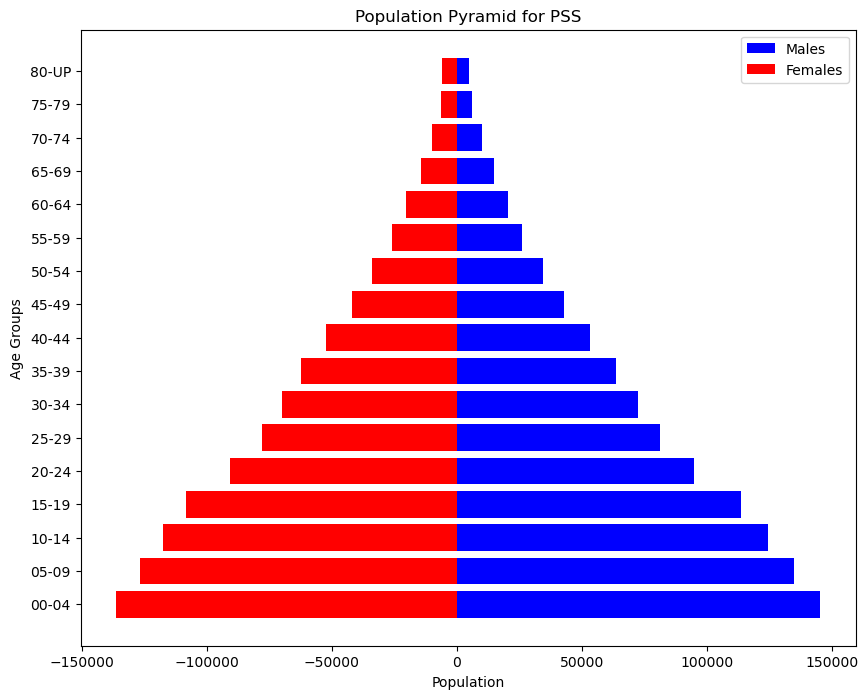

In [27]:
world_pop = population_df(year=2000, sex='all', age_range=(0, 80), place_code='PSS')
plot_population_pyramid(world_pop, 'PSS')

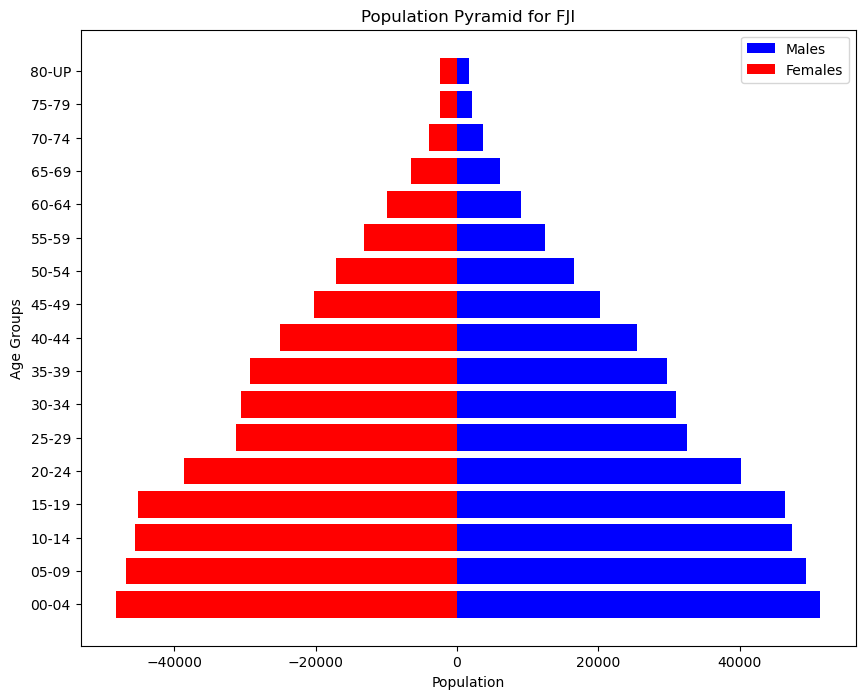

In [19]:
world_pop = population_df(year=2000, sex='all', age_range=(0, 80), place_code='FJI')
plot_population_pyramid(world_pop, 'FJI')

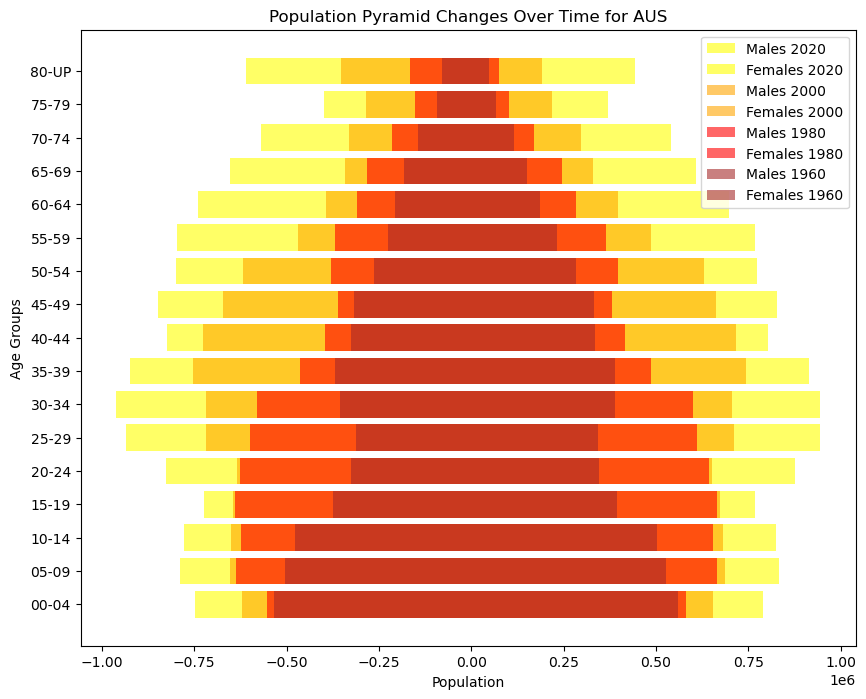

In [21]:
def plot_population_pyramid_over_time(years, place_code):
    """Plot population pyramids for multiple years on a single graph using Matplotlib."""
    fig, ax = plt.subplots(figsize=(10, 8))

    colors = ['yellow', 'orange', 'red', 'brown']
    for i, year in enumerate(years):
       
        df = population_df(year=year, sex='all', age_range=(0, 80), place_code=place_code)

        # age groups
        age_groups = df['age']

        # Plot males (positive values)
        ax.barh(age_groups, df['male'], color=colors[i], alpha=0.6, label=f'Males {year}')

        # Plot females (negative values)
        ax.barh(age_groups, -df['female'], color=colors[i], alpha=0.6, label=f'Females {year}')

    # labels and titles
    ax.set_xlabel('Population')
    ax.set_ylabel('Age Groups')
    ax.set_title(f'Population Pyramid Changes Over Time for {place_code}')
    ax.legend()

    plt.show()

    return ax

# Define years to visualize
years = [2020, 2000, 1980, 1960]

# Generate population pyramids for Australia over time
ax = plot_population_pyramid_over_time(years, 'AUS')

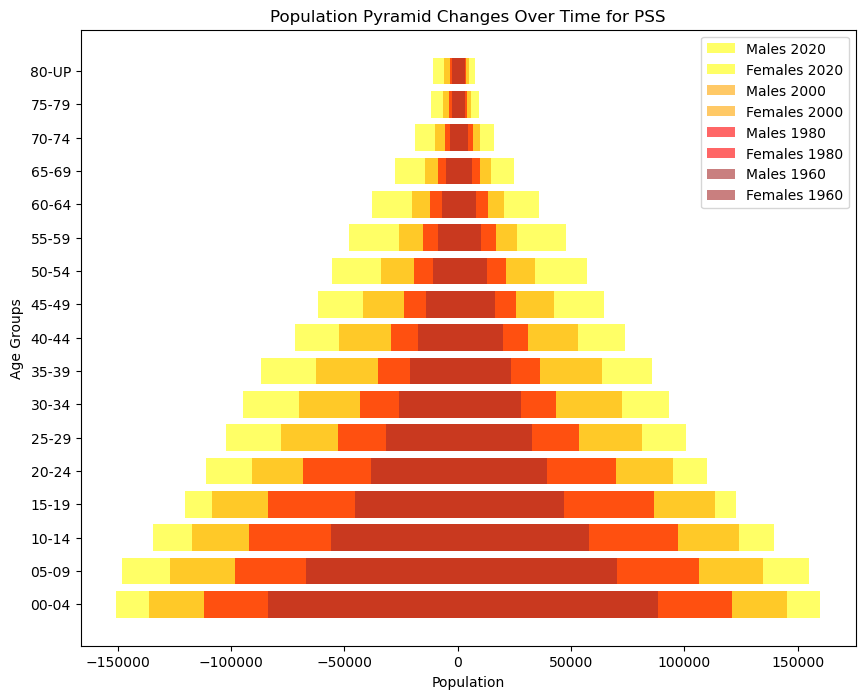

<Axes: title={'center': 'Population Pyramid Changes Over Time for PSS'}, xlabel='Population', ylabel='Age Groups'>

In [24]:
plot_population_pyramid_over_time(years, 'PSS')

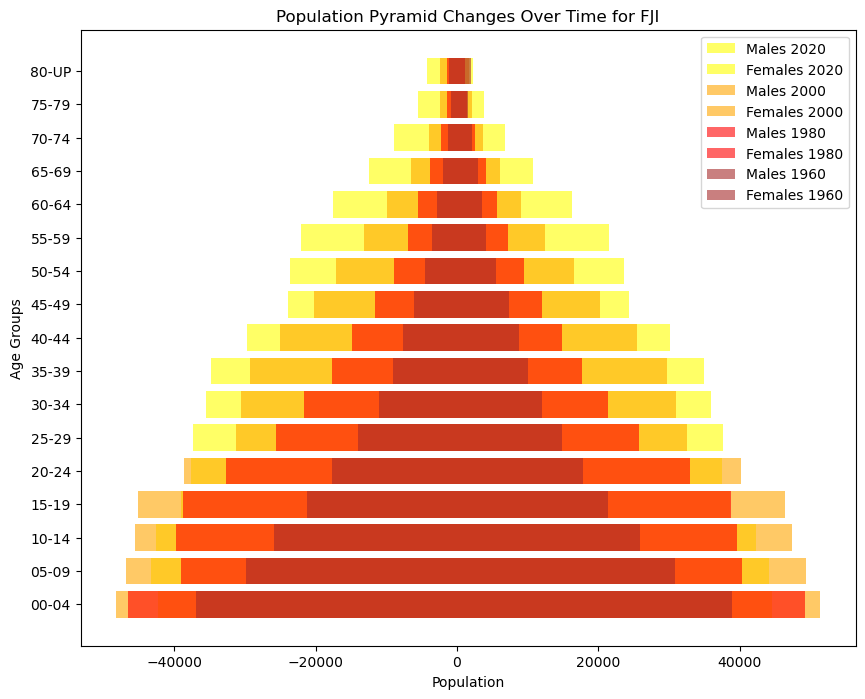

<Axes: title={'center': 'Population Pyramid Changes Over Time for FJI'}, xlabel='Population', ylabel='Age Groups'>

In [25]:
plot_population_pyramid_over_time(years, 'FJI')


## Fertility and Mortality Rates

In [3]:
import seaborn as sea

countries = ["FJI", "SLB", "VUT", "WSM", "FSM", "KIR", "TON", "MHL", "PLW", "TUV", "NRU"]

variable_labels_TFRT = {"SP.DYN.TFRT.IN": "Fertility Rate"}

DYN_PSS_TFRT = wbdata.get_dataframe(variable_labels_TFRT, country=countries)
print(DYN_PSS_TFRT)

DYN_PSS_TFRT_cleaned = DYN_PSS_TFRT.dropna().reset_index()

              Fertility Rate
country date                
Fiji    2023             NaN
        2022           2.462
        2021           2.475
        2020           2.495
        2019           2.519
...                      ...
Samoa   1964           7.667
        1963           7.656
        1962           7.646
        1961           7.641
        1960           7.646

[704 rows x 1 columns]


NameError: name 'country' is not defined

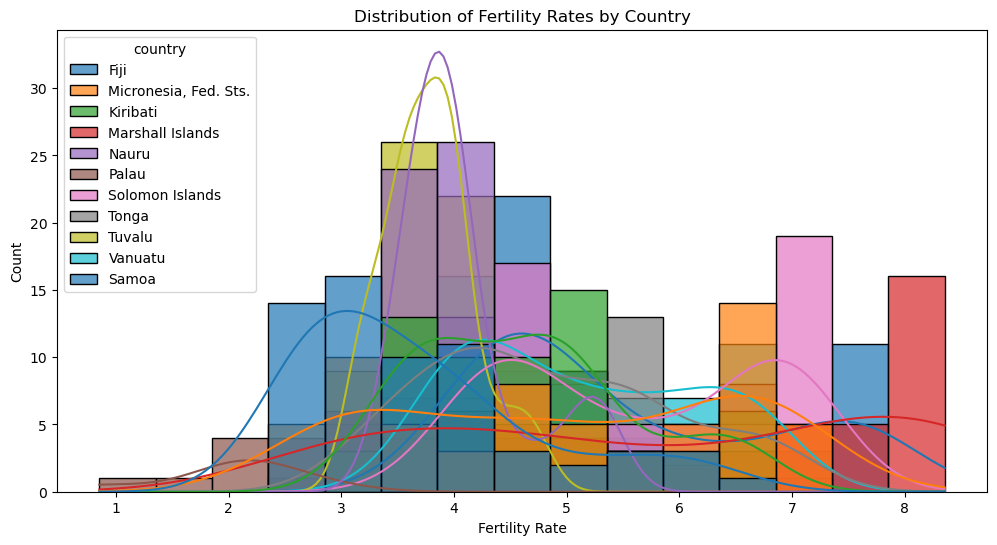

In [13]:
plt.figure(figsize=(12, 6))
sea.histplot(
    data=DYN_PSS_TFRT_cleaned, 
    x="Fertility Rate", 
    hue="country",  # Different colors for different countries
    bins=15, 
    kde=True, 
    palette="tab10",
    alpha=0.7
)

# Customizing the plot
plt.title("Distribution of Fertility Rates by Country")
plt.xlabel("Fertility Rate")
plt.ylabel("Count")
plt.legend(country)
plt.show()

In [15]:
variable_labels_IMRT = {"SP.DYN.IMRT.IN": "Mortality Rate"}

DYN_PSS_IMRT = wbdata.get_dataframe(variable_labels_IMRT, country=countries)
print(DYN_PSS_IMRT)

DYN_PSS_IMRT_cleaned = DYN_PSS_IMRT.dropna().reset_index()

              Mortality Rate
country date                
Fiji    2023             NaN
        2022            23.6
        2021            23.3
        2020            22.6
        2019            21.6
...                      ...
Samoa   1964            73.9
        1963            69.0
        1962            71.3
        1961            73.9
        1960            76.7

[704 rows x 1 columns]


NameError: name 'country' is not defined

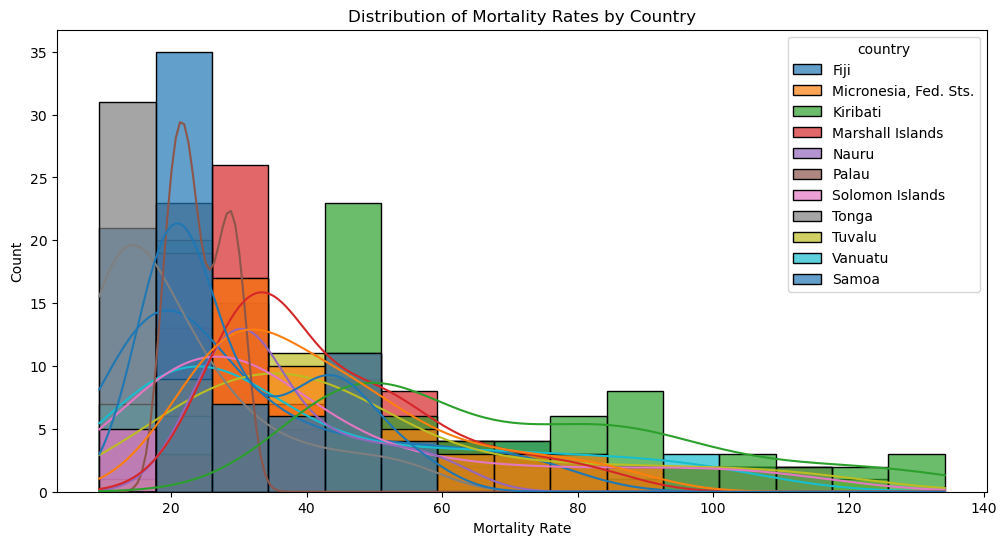

In [16]:
plt.figure(figsize=(12, 6))
sea.histplot(
    data=DYN_PSS_IMRT_cleaned, 
    x="Mortality Rate", 
    hue="country",  # Different colors for different countries
    bins=15, 
    kde=True, 
    palette="tab10",
    alpha=0.7
)

# Customizing the plot
plt.title("Distribution of Mortality Rates by Country")
plt.xlabel("Mortality Rate")
plt.ylabel("Count")
plt.legend(country)
plt.show()

## Agricultural Supply

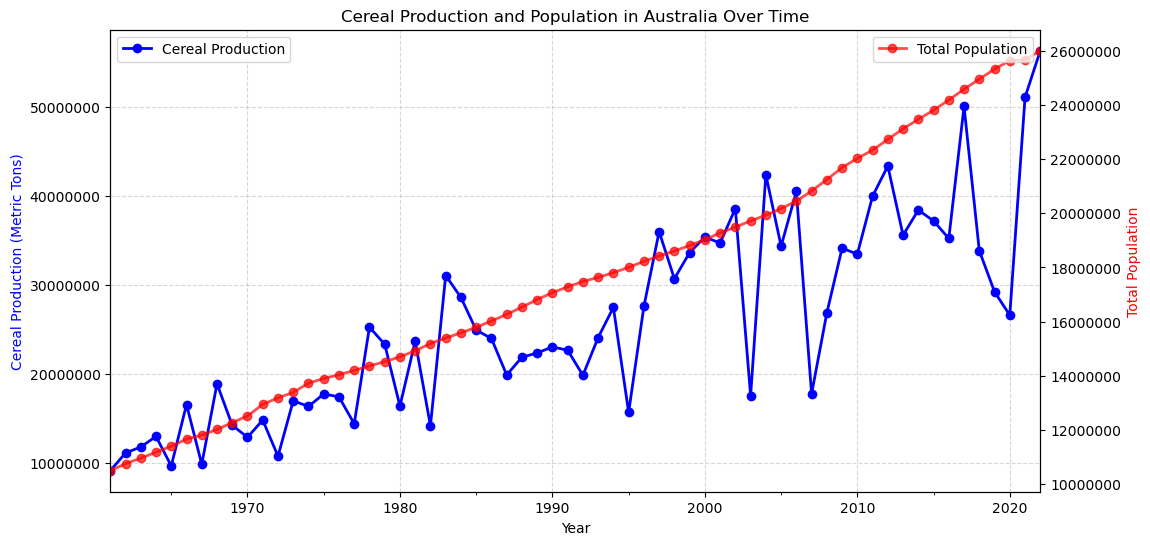

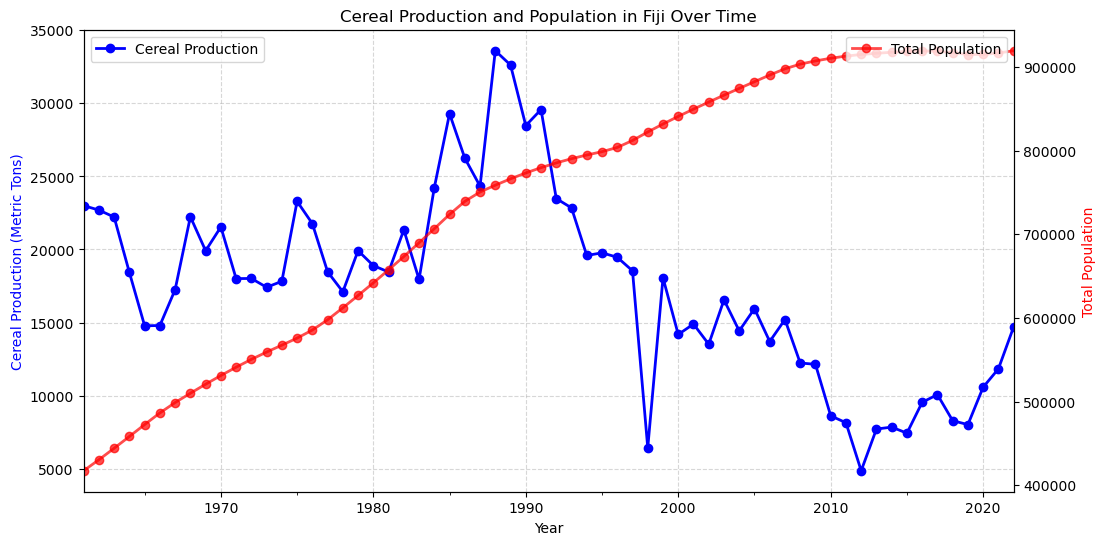

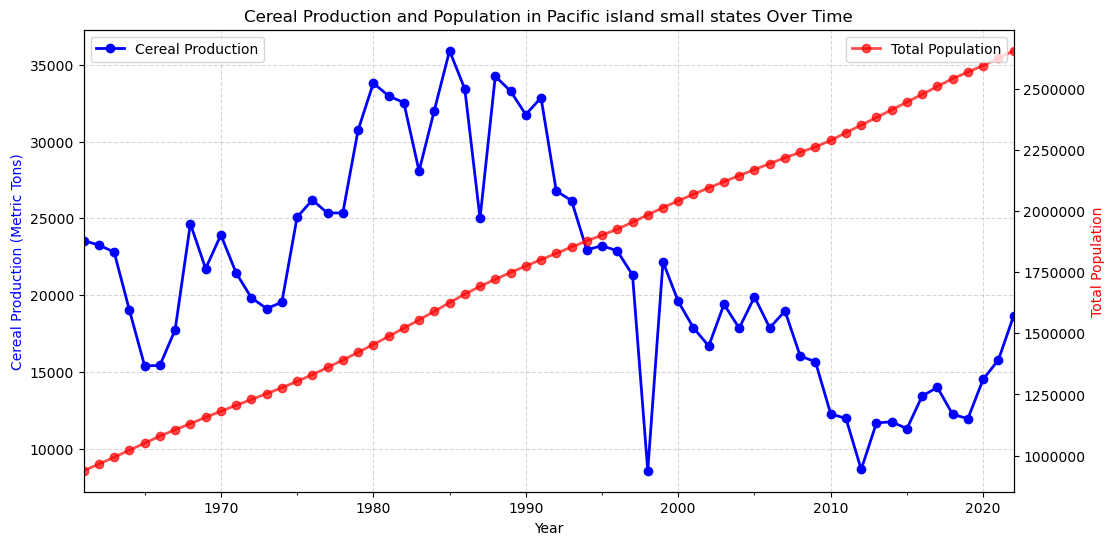

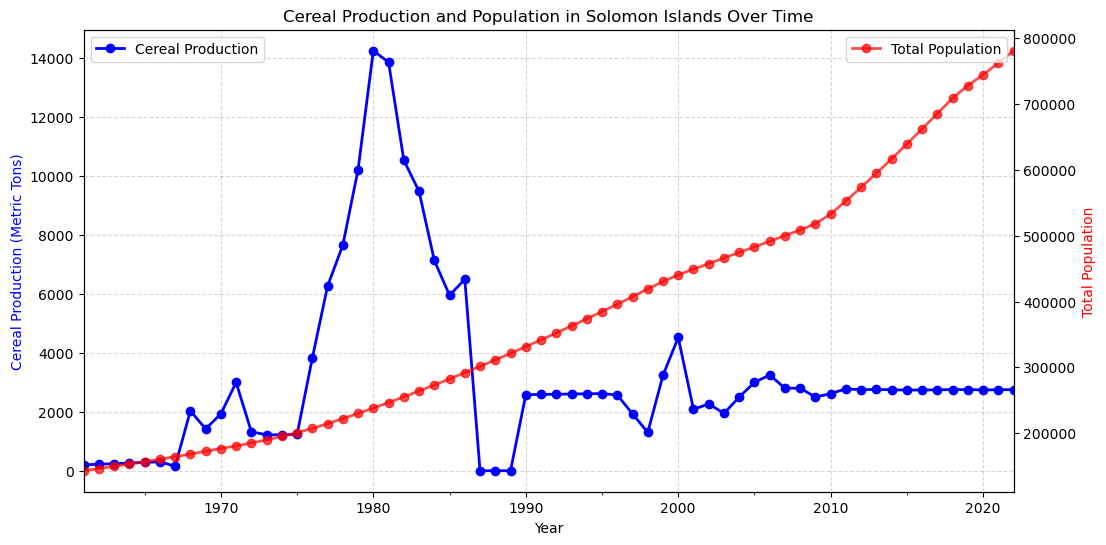

In [34]:
from matplotlib.ticker import ScalarFormatter

#Plotting cereal production across various countries alongside their growth in population
#We will compare the graphs to see if it follows Malthus' theory
#We can also see how agricultural production differs across Pacific Island States
pd.options.plotting.backend = 'plotly'

#Create variables for Cereal Production and Population as a comparison
variable_labels = {
                "AG.PRD.CREL.MT":"Cereal Production (Metric Tons)",
                   "SP.POP.TOTL":"Total Population"
                  }

#I used these countries because they are Islands in the Pacific with data that go back to 1965
countries = ["AUS", "FJI", "SLB", "PSS"]

#Create dataframe that includes necessary variables
df1 = wbdata.get_dataframe(variable_labels, country = countries, parse_dates = True).dropna()

#Create two series to display cereal production and population
df1_cereal = df1["Cereal Production (Metric Tons)"].unstack(level="country").dropna()
df1_pop = df1["Total Population"].unstack(level="country").dropna()

pd.options.plotting.backend = 'matplotlib'

#Plot individual country comparisons
for country in df1_cereal.columns:
    fig, ax1 = plt.subplots(figsize=(12, 6)) #Configure for aesthetics
    ax2 = ax1.twinx()  #Create a second y-axis

    df1_cereal[country].plot(ax=ax1, marker="o", linewidth=2, label="Cereal Production", color='blue')
    df1_pop[country].plot(ax=ax2, marker="o", linewidth=2, alpha=0.7, label="Total Population", color='red')

    ax1.set_title(f"Cereal Production and Population in {country} Over Time")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Cereal Production (Metric Tons)", color='blue')
    ax2.set_ylabel("Total Population", color='red')

    #Get rid of scientific notation for each graph
    ax1.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax1.ticklabel_format(style="plain", axis="y")
    ax2.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax2.ticklabel_format(style="plain", axis="y")
    
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.show()

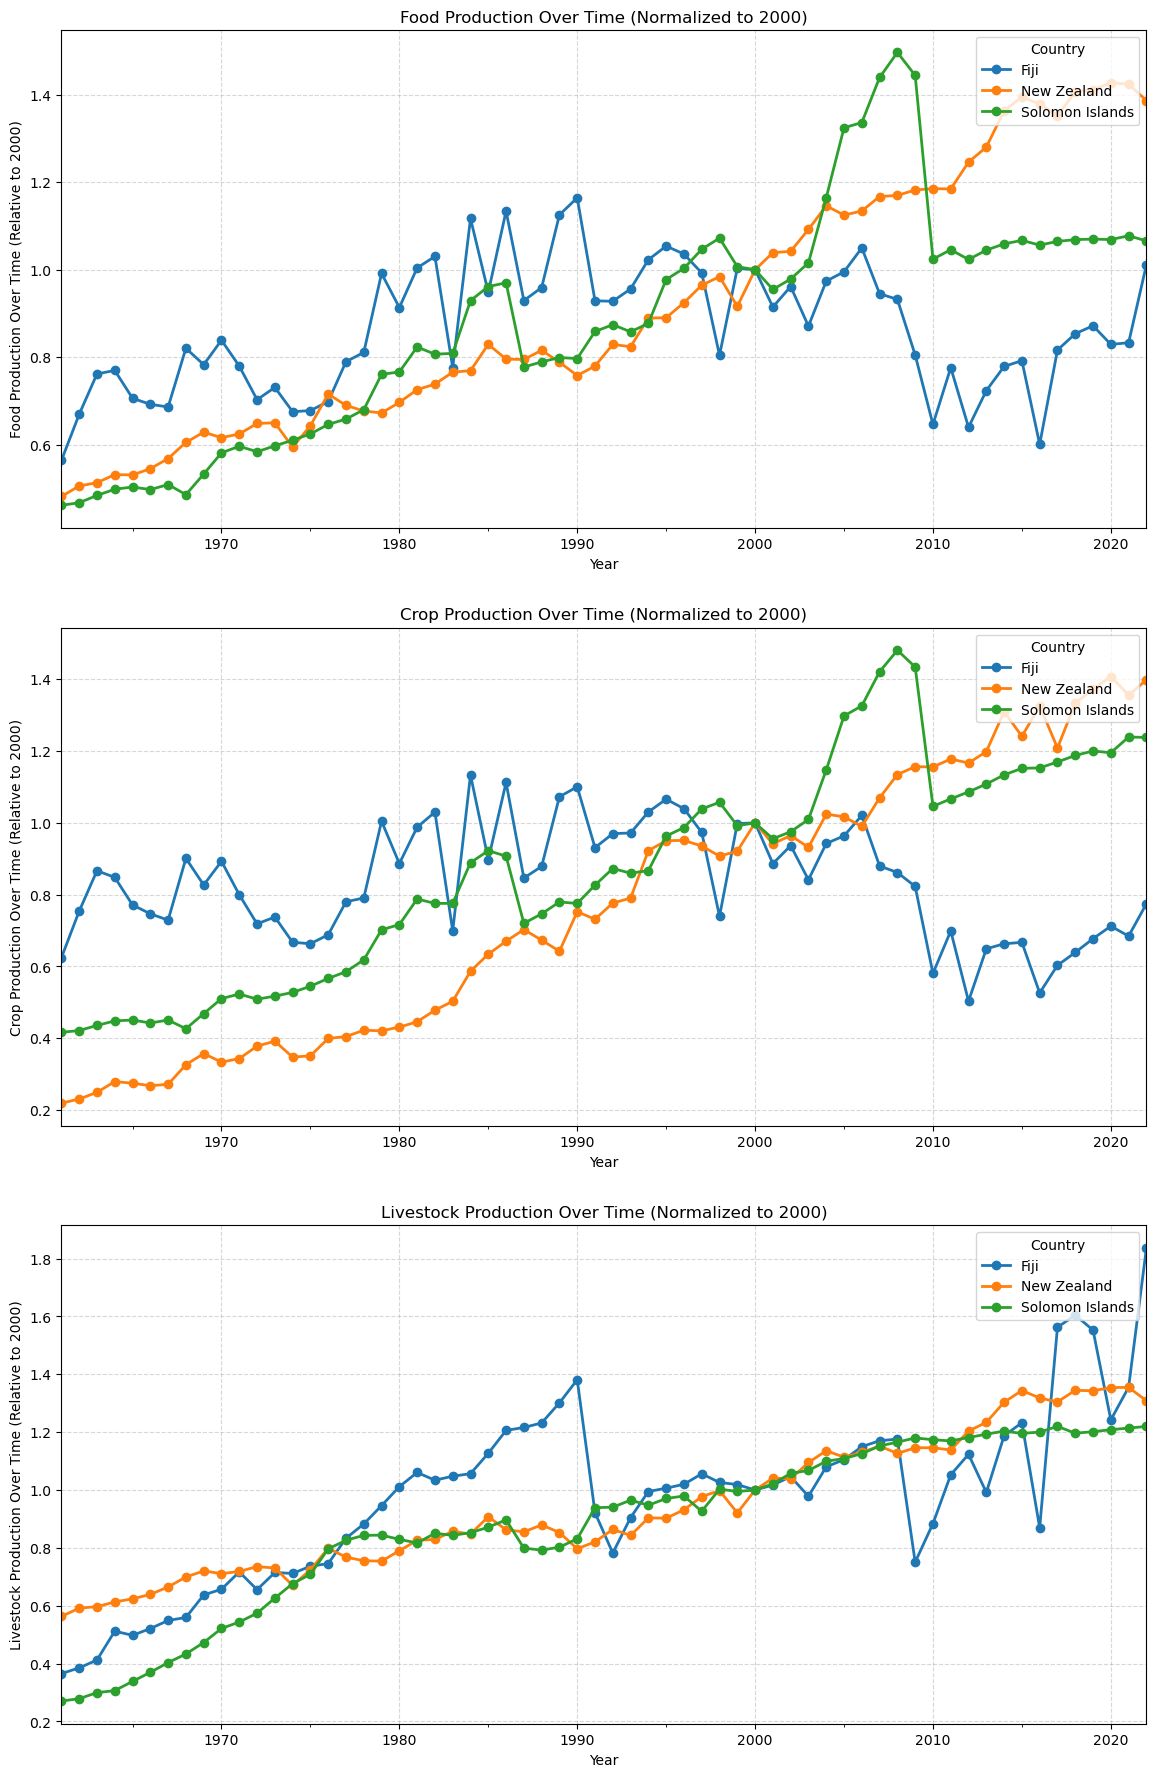

In [28]:
#Plot graphs for food production, crop production, and livestock for different states
#Normalized to one year (2000)
#Compare production across different countries

#Set backend for initial data retrieval
pd.options.plotting.backend = 'plotly'

#Define necessary variables
vars = {
    "AG.PRD.FOOD.XD":"Food Production",
    "AG.PRD.CROP.XD":"Crop Production",
    "AG.PRD.LVSK.XD":"Livestock Production"
}

#Get countries with enough data for food, crop, and livestock indexes
places = ["NZL", "FJI", "SLB"]

#Retrieve new data
df2 = wbdata.get_dataframe(vars, country=places, parse_dates=True).dropna()

#Get 3 series
df2_food = df2["Food Production"].unstack(level="country")
df2_crop = df2["Crop Production"].unstack(level="country")
df2_livestock = df2["Livestock Production"].unstack(level="country")

#Normalize data to year 2000
base_year = "2000-01-01" #Uses string as per dataframe

def normalize(df2, base_year):
    """Normalize a dataframe by a base year."""
    if base_year in df2.index:
        return df2 / df2.loc[base_year]
    else:
        print(f"Warning: Base year {base_year} not found in dataset.")
        return df2

#Create new series based on normalization
df2_food_norm = normalize(df2_food, base_year)
df2_crop_norm = normalize(df2_crop, base_year)
df2_livestock_norm = normalize(df2_livestock, base_year)

#Set backend for plotting
pd.options.plotting.backend = 'matplotlib'

#Plot raw vs normalized data
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 22))

plot_titles = [
    ("Food Production Over Time", df2_food_norm),
    ("Crop Production Over Time", df2_crop_norm),
    ("Livestock Production Over Time", df2_livestock_norm)
]

for i, (title, norm_data) in enumerate(plot_titles):
    #Normalized data plot
    norm_data.plot(ax=axes[i], marker="o", linewidth=2)
    axes[i].set_title(f"{title} (Normalized to 2000)")
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel(f"{title} (Relative to 2000)")
    axes[i].grid(True, linestyle="--", alpha=0.5)
    axes[i].legend(title="Country", loc = "upper right")

## Conclusions

## Works Cited

1) https://wmo.int/news/media-centre/climate-change-transforms-pacific-islands#:~:text=A%20triple%20whammy%20of%20accelerating,existence%20because%20of%20climate%20change.

2. https://research.fit.edu/media/site-specific/researchfitedu/coast-climate-adaptation-library/pacific-islands/micronesia/IFAD.--CC-Impacts.pdf

3) https://sdgs.un.org/statements/pacific-small-island-developing-states-psids-11347

All population data from World Bank Data. [Documentation](https://wbdata.readthedocs.io/en/stable/)
.